# Applying the GP framework (Steps 1 to 5)

In [1]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sb
import matplotlib.colors as colors

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Step 1: Problem definition

In this experiment we would like to interpolate satelite observations of glacier elevation with the help of other variables. The goal is to generate a maps of elevation change with uncertainties. These results will be used to estimate sea level change. 

## Step 2: Initial data exploration

The data has approximately 532,051 data points $\text{N}$, 7 input dimensions $\text{D}_{\text{in}}$, and 1 output dimension $\text{D}_{\text{out}}$. This is on the larger side of dataset size tractable with an exact GP. It would thefore be wise to also consider training a neural network with a GP as a wrapper. However, we will see that it is still possible to apply GPs in this case.

In [2]:
# Load the data
df = pd.read_csv('data/glacier_dataset_targets.csv', usecols=['elev', 'ocean_dist', 'slope', 'vel', 'aspect', 'dhdt_filt', 'x', 'y', 'date_min', 'date_max'])

In [80]:
df

,elev,ocean_dist,slope,vel,aspect,x,y,dhdt_filt,date_max,date_min
0,397.11383,4008.621682,5.197093,35.433570,102.33453,98730.00,-3292241.2,-0.841598,737713.0,732235.0
1,402.80795,4355.272741,4.037823,60.513220,102.66707,98762.75,-3291823.2,-0.815259,737713.0,732235.0
2,407.51212,4806.639575,2.551501,57.453743,109.58238,98789.48,-3291306.5,-0.921331,737713.0,732235.0
3,414.10504,5224.893579,1.833211,53.611755,140.86260,98810.63,-3290840.5,-1.034803,737713.0,732235.0
4,428.24548,5681.412747,2.089108,49.410866,161.33139,98704.96,-3290392.8,-1.086033,737713.0,732235.0
...,...,...,...,...,...,...,...,...,...,...
497135,384.22247,1528.472804,5.664680,1.496897,302.40158,469215.40,-765207.1,-0.288429,737440.0,732113.0
497136,385.54993,1540.715409,5.596981,1.509064,301.34116,469229.25,-765215.2,-0.229011,737471.0,732113.0
497137,444.31805,1477.312500,3.302001,1.991713,211.50058,470123.72,-765149.8,-0.156538,737683.0,731900.0
497138,442.05338,1803.294730,2.370549,3.348576,124.18109,470654.30,-765440.3,-0.228664,737683.0,731900.0


## Step 3: Domain expertise

Elevation change can be positive or negative. We know also that the data is the results of a linear regression applied to raw data collected over the period of several days using the satellites ICESAT and ICESAT-2. As the data is geophysical, points closer together should be more similar. The variables are defined as follows:

| name       | description |
|------------|---------------------------------------------------|
| elev_change| 'filtered' elevation change in [m/yr]             |
| elev       | topographic  elevation from altimetry [m]         |
| ocean_dist | distance to ocean [m]                             |
| slope      | topographic surface slope [m per m]               |
| vel        | surface velocity [m/yr]                           |
| aspect     | topographic aspect [degrees from north]           |
| x          | cartesian x coodinate in epsg 3413 projeciton [m] |
| y          | cartesian y coodinate in epsg 3413 projeciton [m] |



## Step 4: Training, validation and test sets

We are looking at filling in gaps over spatial coordinates, the first thing to do is to plot the data as in the same format as the way we would like to output it. It seems like the area with the least amount of data is the South of Greenland. The validation and test set should be similar in distribution to the areas we actually want to predict. 

Looking at the scatter plots and histograms we can see that:
* spread in x is approximately gaussian
* spread in elevation and y show a log-normal distribution 
* ocean distance exhibits a linear drop off
* slope, elevation change, and velocity have many oultier and could use a log-tranformation to help inference
* aspect distribution is multi-modal

Based on this information, we suggest that the data is split along the tracks.

<Axes: xlabel='x', ylabel='y'>

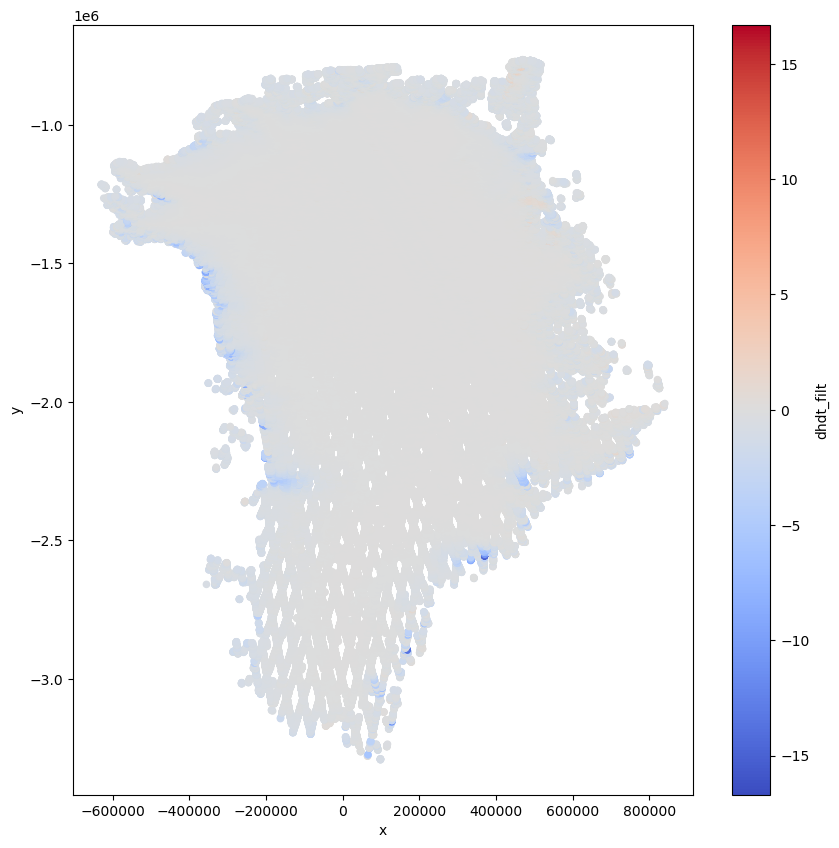

In [236]:
# Simple scatter plot of target variable
df.plot.scatter(x='x', y='y', c='dhdt_filt', figsize=(10,10), cmap='coolwarm', norm=colors.CenteredNorm(),)

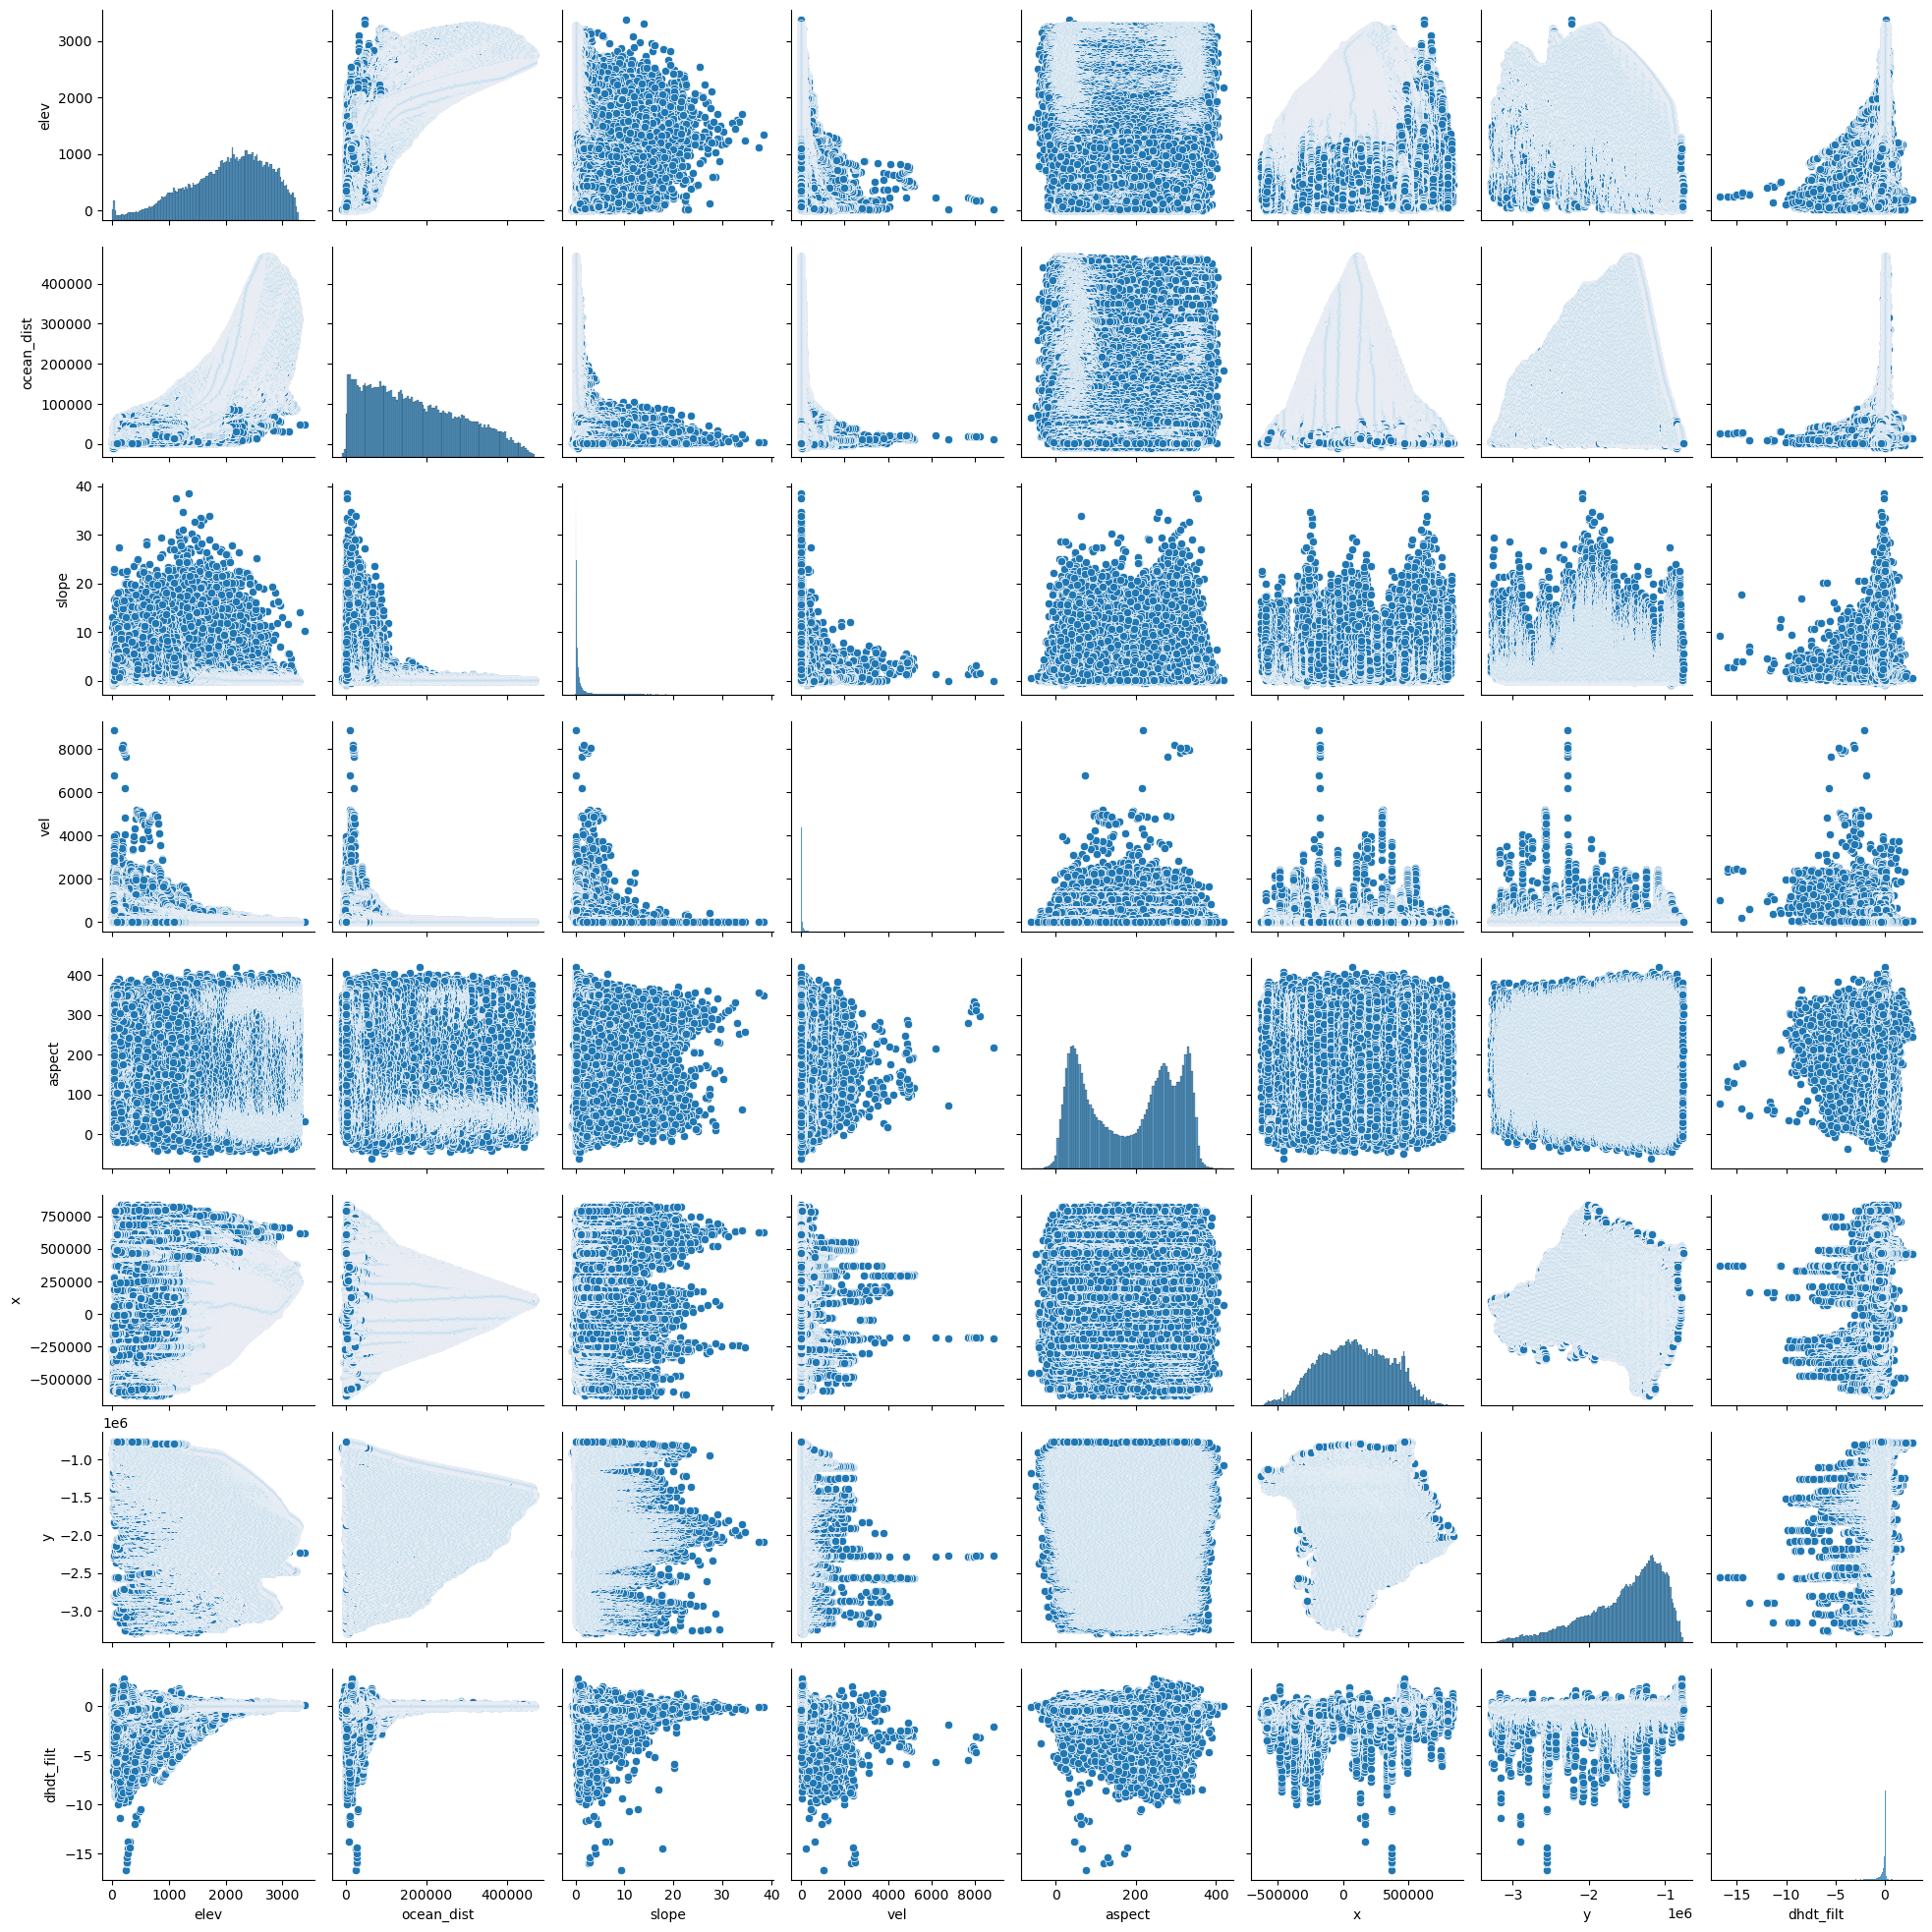

In [7]:
# Pairplot of all variables
sb.pairplot(df)

In [3]:
# Split data into training, validation and test sets

df['group'] = df.groupby(['date_min', 'date_max']).cumcount()  # group along tracks

## Split into training and evaluation set (70%/30%)
gss1 = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
indices1 = gss1.split(X=df[['elev', 'ocean_dist', 'slope', 'vel', 'aspect', 'x', 'y']
                           ].values, y=df['dhdt_filt'].values, groups=df.group.values)
for i in indices1:
    (train_index, eval_index) = i
    print(
        f"  Train: index={train_index}, group={df.group.values[train_index]}")
    print(f"  Test:  index={eval_index}, group={df.group.values[eval_index]}")
train_df = df.iloc[train_index]

## Split into validation and test set (33%/67%)
eval_df = df.iloc[eval_index]
gss2 = GroupShuffleSplit(n_splits=1, train_size=.3333, random_state=42)
indices2 = gss2.split(X=eval_df[['elev', 'ocean_dist', 'slope', 'vel', 'aspect', 'dhdt_filt', 'x', 'y']].values,
                      y=eval_df['dhdt_filt'].values, groups=eval_df.group.values)
for i in indices2:
    (val_index, test_index) = i
    print(
        f"  Train: index={val_index}, group={eval_df.group.values[val_index]}")
    print(
        f"  Test:  index={test_index}, group={eval_df.group.values[test_index]}")
val_df = eval_df.iloc[val_index]
test_df = eval_df.iloc[test_index]


  Train: index=[     0      1      2 ... 497136 497138 497139], group=[    0     1     2 ...   875 18721    27]
  Test:  index=[     4      6      7 ... 497128 497134 497137], group=[    4     6     7 ...  1741 18719 18720]
  Train: index=[     1      5      8 ... 150135 150136 150142], group=[    6     6     6 ... 20379 10226 18719]
  Test:  index=[     0      2      3 ... 150140 150141 150143], group=[    4     7     4 ... 20385  1741 18720]


In [5]:
# Save the data
# train_df.to_csv('data/training_set.csv')
# val_df.to_csv('data/validation_set.csv')
# test_df.to_csv('data/test_set.csv')